In [1]:
# Import packages
import re
import os
import string
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt

# Analytics/Metrics
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer


## TWEEPY STUFF
# Twitter Authentication
from src import ACCESS_TOKEN, ACCESS_TOKEN_SECRET, CONSUMER_KEY, CONSUMER_SECRET
# Twitter Scraping Class
from src import TwitterClient
# Class for cleanup
from src import TweetAnalyzer
# NLP and Metrics

# Visualization


c:\Users\t_zim\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Project Methodology

- [User Input] - Input query terms
- [Tweet Scraping] - Execute query on one term at a time (username or string) <- NOT DOING STRING YET
- [Tweet Cleaning] - Clean tweets and format into dataframe
- [Tweet Engineering] - Combine dataframes for all query terms in a subject area
- [NLP and Metrics] - Compute metrics and transformations
- [Visualize]

## Query Terms

In [22]:
#SUBJECT = "Space"

Number_of_Tweets = 250

# Input a screen name and see their recent tweets
#USER = 'NASA'

# Input a list of query terms and GET tweets
#QUERY = ['NASA', 'space station', 'hubble']

SUBJECT = "Grammys"
USER = 'RecordingAcad'
QUERY = ['grammy', 'winner', 'best', 'album']

## Tweet Scraping

### By User Name

In [23]:
# Config params
twitter_client = TwitterClient(twitter_user=USER)

# Print if you wish
#print(twitter_client.get_user_timeline_tweets(Number_of_Tweets))

# Retrieve tweets
tweets = twitter_client.get_user_timeline_tweets(Number_of_Tweets)
# Format tweets into DF
tweet_cleaner = TweetAnalyzer()
df = tweet_cleaner.tweets_to_data_frame(tweets)

Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id


### By Search Term

In [13]:
# Config params
twitter_client = TwitterClient(query_term=QUERY)

# Print if you wish
#print(twitter_client.get_query_tweets(Number_of_Tweets))

# Retrieve tweets
tweets = twitter_client.get_query_tweets(Number_of_Tweets)
# Format tweets into DF
tweet_cleaner = TweetAnalyzer()
df = tweet_cleaner.tweets_to_data_frame(tweets)

## Tweet Cleaning

Steps:
- Remove extra columns
- Remove unnecessary characters
- Remove HTML tags, hyperlinks

In [4]:
#df = pd.read_csv("C:\\Users\\hlmq\\OneDrive - Chevron\\Desktop\\Projects\\Twitter News\\sample tweets\\1000tweets.csv")
df = pd.read_csv("C:\\Users\\t_zim\\Desktop\\Projects\\Twitter_Project\\1000_python_tweets.csv")


In [24]:
# Extract pieces out of tweets and put into df columns
df['hashtags'] = df['tweet'].apply(TweetAnalyzer.extract_hashtags)
df['mentions'] = df['tweet'].apply(TweetAnalyzer.extract_mentions)

# Clean special characters from tweet text
df['tweet'] = df['tweet'].apply(TweetAnalyzer.clean_special_chars)

# Compute length of each tweet (exclude really short ones)
df['tweet_length'] = df['tweet'].apply(TweetAnalyzer.count_caption_words)

# Remove short tweets.  Require that tweet is minimum of 5 words long.
df = df[df['tweet_length']>5]

## Tweet File Joining

In [6]:
# Combine datasets for a subject area

## NLP and Metrics

Steps:

- Topic Modeling (BERTopic)

- Analyze Sentiment for each tweet
- Count # of tweets in subject [GLOBAL]
- Count # of tweets in topic [Local]
- CountWordFrequency across subject
- Log accounts (most frequent mentions or other?)


In [25]:
# Prepare embeddings
docs = df['tweet'].tolist()
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(docs, show_progress_bar=True)

vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english", min_df=2)

topic_model = BERTopic(nr_topics = 10, #max number of topics
                       language = 'english',
                       vectorizer_model = vectorizer_model,
                       calculate_probabilities = True,
                       verbose=True)

topics, probabilities = topic_model.fit_transform(docs, embeddings)

Batches: 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]
2023-02-05 22:20:55,502 - BERTopic - Reduced dimensionality
2023-02-05 22:20:55,516 - BERTopic - Clustered reduced embeddings


ValueError: max_df corresponds to < documents than min_df

In [26]:
# Topic -1 is the catch-all bin for outliers.
# Need to modify min_df.  Believe this is the minimum number of obs to create a topic.
# From word frequency, believe ngram = 2 is good.
# ACTION: Generate more tweets and test with different min_df value.

topic_model.get_topic_freq().head()

,Topic,Count
0,-1,46


In [27]:
topic_model.get_topic_info()

TypeError: 'NoneType' object is not callable

In [28]:
# Sentiment analysis
#df['sentiment'] = np.array([tweet_analyzer.analyze_sentiment(tweet) for tweet in df['tweets']])

# Count total len of df
total_tweets_in_subject = len(df)
print(total_tweets_in_subject)

# Count len of df where topic == some value
total_tweets_in_topic = []

46


Text(0.5, 1.0, 'Most Common Words from this Subject')

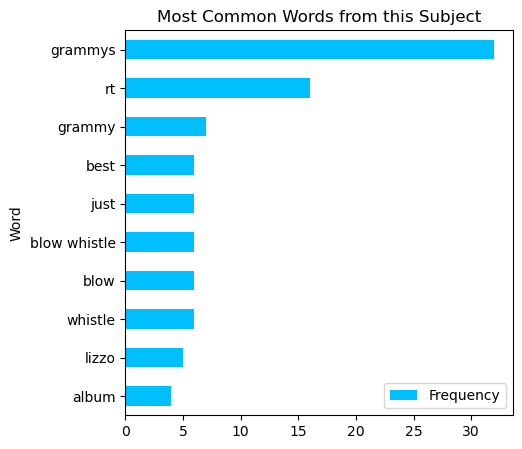

In [29]:
# CountWordFrequency

#Create DTM
cv = CountVectorizer(ngram_range = (1,3), stop_words='english')
dtm = cv.fit_transform(df['tweet'])
words = np.array(cv.get_feature_names_out())

#Look at top 15 most frequent words
freqs=dtm.sum(axis=0).A.flatten()
index=np.argsort(freqs)[-10:]

# Construct dataframe
WordFreq = pd.DataFrame.from_records(list(zip(words[index], freqs[index])))
WordFreq.columns = ['Word', 'Frequency']

# Plot horizontal bar graph
fig, ax = plt.subplots(figsize=(5, 5))
WordFreq.sort_values(by='Frequency').plot.barh(
                      x='Word',
                      y='Frequency',
                      ax=ax,
                      color="deepskyblue")

plt.title("Most Common Words from this Subject")

In [30]:
vectorizer = CountVectorizer(analyzer=lambda x: x)
dtm = vectorizer.fit_transform(df['mentions']).toarray()
mention = np.array(vectorizer.get_feature_names_out())


#Look at top 5 most frequent mentions
freqs=dtm.sum(axis=0).flatten()
index=np.argsort(freqs)[-5:] 

# Construct dataframe
Mentions = pd.DataFrame.from_records(list(zip(mention[index], freqs[index]))) 
Mentions.columns = ['Mention', 'Frequency']

Mentions.sort_values(by='Frequency', ascending=False, inplace=True)
Mentions.reset_index(inplace=True, drop=True)
Mentions

,Mention,Frequency
0,lukecombs,2
1,CBS,2
2,Beyonce,2
3,Adele,2
4,JoJoWright,1


## Output Dataset

In [ ]:
# Create name of file

dirname = "C:\\Users\\t_zim\\Desktop\\Data\\Twitter\\"

# Just creates the string with {path} and {filename} ready to go
OUT_FILE = os.path.join(dirname, "{timestamp}_{subject}tweets.csv".format(timestamp=date.today(), subject=SUBJECT))
print(OUT_FILE)

In [ ]:
df.to_csv(OUT_FILE, index=False)